## Initialization

In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf

--2022-05-28 06:11:03--  https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256815066 (245M)
Saving to: ‘challenge3.gwf’

challenge3.gwf      100%[===================>] 244.92M  9.34MB/s    in 35s     

2022-05-28 06:11:39 (7.03 MB/s) - ‘challenge3.gwf’ saved [256815066/256815066]



### Read data

In [34]:
sampling_rate=2048 #needs to be high enough for the signals found in steps above
#sampling_rate=4096 #needs to be high enough for the signals found in steps above
duration=2.4 #needs to be long enough for the signals found in steps above
start_time=2481.8 #needs to be set so that the segment defined by [start_time,start_time+duration] contains the signal


psd_duration = duration * 32
psd_start_time = start_time - psd_duration

interferometers = bilby.gw.detector.InterferometerList([])
for ifo_name in ['H1','L1']:
    ifo=bilby.gw.detector.get_empty_interferometer(ifo_name)
    ifo.set_strain_data_from_frame_file('challenge3.gwf',sampling_rate, duration, start_time=start_time ,channel=ifo_name+':CHALLENGE3')
    
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity.from_frame_file('challenge3.gwf', psd_start_time 
                                                                                        , psd_duration=psd_duration, 
                                                                                        sampling_frequency=sampling_rate, 
                                                                                        channel=ifo_name+':CHALLENGE3')
    
    #gwpy_strain = TimeSeries.read('challenge3.gwf', channel=ifo_name+":CHALLENGE3")
    #sampling_rate_raw=1/gwpy_strain.dt
    #segment = (int((start_time-psd_duration)*sampling_rate_raw.value), int((start_time)*sampling_rate_raw.value))
    #ifo_psd_data = gwpy_strain[segment[0]:segment[1]]
    
    #psd_alpha = 2 * ifo.strain_data.roll_off / duration
    #ifo_psd = ifo_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
    #ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=ifo_psd.frequencies.value, psd_array=ifo_psd.value)
    
    interferometers.append(ifo)

07:06 bilby INFO    : Reading data from frame file challenge3.gwf
07:06 bilby INFO    : Successfully loaded H1:CHALLENGE3.
07:06 bilby INFO    : Reading data from frame file challenge3.gwf
07:06 bilby INFO    : Successfully loaded H1:CHALLENGE3.
07:06 bilby INFO    : Tukey window PSD data with alpha=0.1, roll off=0.2
07:06 bilby INFO    : Reading data from frame file challenge3.gwf
07:06 bilby INFO    : Successfully loaded L1:CHALLENGE3.
07:06 bilby INFO    : Reading data from frame file challenge3.gwf
07:06 bilby INFO    : Successfully loaded L1:CHALLENGE3.
07:06 bilby INFO    : Tukey window PSD data with alpha=0.1, roll off=0.2


07:06 bilby INFO    : Generating frequency domain strain from given time domain strain.
07:06 bilby INFO    : Applying a tukey window with alpha=0.16667344862665312, roll off=0.2


ValueError: operands could not be broadcast together with shapes (2458,) (2459,) 

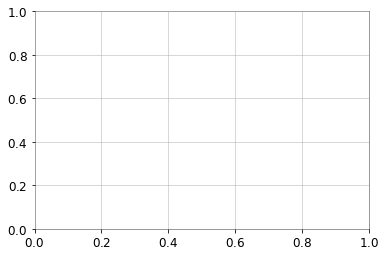

In [35]:
fig, ax = plt.subplots()
idxs = interferometers[0].strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(interferometers[0].strain_data.frequency_array[idxs],
          np.abs(interferometers[0].strain_data.frequency_domain_strain[idxs]))
ax.loglog(interferometers[0].power_spectral_density.frequency_array[idxs],
          interferometers[0].power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

In [27]:
interferometers[0].maximum_frequency = 1024
interferometers[1].maximum_frequency = 1024

## Low dimensional analysis

In general a compact binary coalescence signal is described by 15 parameters describing the masses, spins, orientation, and position of the two compact objects along with a time at which the signal merges. The goal of parameter estimation is to figure out what the data (and any cogent prior information) can tell us about the likely values of these parameters - this is called the "posterior distribution of the parameters".

To start with, we'll analyse the data fixing all but a few of the parameters to known values (in Bayesian lingo - we use delta function priors), this will enable us to run things in a few minutes rather than the many hours needed to do full parameter estimation.

We'll start by thinking about the mass of the system. We call the heavier black hole the primary and label its mass $m_1$ and that of the secondary (lighter) black hole $m_2$. In this way, we always define $m_1 \ge m_2$. It turns out that inferences about $m_1$ and $m_2$ are highly correlated, we'll see exactly what this means later on.

Bayesian inference methods are powerful at figuring out highly correlated posteriors. But, we can help it along by sampling in parameters which are not highly correlated. In particular, we define a new parameter called the [chirp mass](https://en.wikipedia.org/wiki/Chirp_mass) to be

$$ \mathcal{M} = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}} $$

and the mass ratio

$$ q = \frac{m_{2}}{m_1} $$

If we sample (make inferences about) $\mathcal{M}$ and $q$, our code is much faster than if we use $m_1$ and $m_2$ directly! Note that so long as equivalent prior is given - one can also sample in the component masses themselves and you will get the same answer, it is just much slower!

Once we have inferred $\mathcal{M}$ and $q$, we can then derive $m_1$ and $m_2$ from the resulting samples (we'll do that in just a moment).

Okay, let's run a short (~1min on a single 2.8GHz core), low-dimensional parameter estimation analysis. This is done by defining a prior dictionary where all parameters are fixed, except those that we want to vary.

### Create a prior

Here, we create a prior fixing everything except the chirp mass, mass ratio, phase and geocent_time parameters to fixed values. The first two were described above. The second two give the phase of the system and the time at which it merges.

In [28]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=8.5,maximum=12.5)
prior['mass_ratio'] = 1.0
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=start_time, maximum=start_time+duration)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066


## Create a likelihood

For Bayesian inference, we need to evaluate the likelihood. In Bilby, we create a likelihood object. This is the communication interface between the sampling part of Bilby and the data. Explicitly, when Bilby is sampling it only uses the `parameters` and `log_likelihood()` of the likelihood object. This means the likelihood can be arbitrarily complicated and the sampling part of Bilby won't mind a bit!

Let's create a `GravitationalWaveTransient`, a special inbuilt method carefully designed to wrap up evaluating the likelihood of a waveform model in some data.

In [29]:
# First, put our "data" created above into a list of interferometers (the order is arbitrary)
#interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=False)

06:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


ValueError: The duration of all interferometers are not the same: H1[duration]=22.3994140625, L1[duration]=22.39990234375

Note that we also specify `time_marginalization=True` and `phase_marginalization=True`. This is a trick often used in Bayesian inference. We analytically marginalize (integrate) over the time/phase of the system while sampling, effectively reducing the parameter space and making it easier to sample. Bilby will then figure out (after the sampling) posteriors for these marginalized parameters. For an introduction to this topic, see [Thrane & Talbot (2019)](https://arxiv.org/abs/1809.02293).

### Run the analysis

Now that the prior is set-up and the likelihood is set-up (with the data and the signal mode), we can run the sampler to get the posterior result. This function takes the likelihood and prior along with some options for how to do the sampling and how to save the data.

In [21]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="10M_sun",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="unif", nlive=500, dlogz=3  # <- Arguments are used to make things fast - not recommended for general use
)

06:35 bilby INFO    : Running for label '10M_sun', output will be saved to 'short'
06:35 bilby INFO    : Using lal version 7.1.6
06:35 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.6;Id: 4f664fffa723bbbe3610d9b29555ee8dc903ab97;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
06:35 bilby INFO    : Using lalsimulation version 3.1.1
06:35 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.1;Id: 9eff85db5692ef91b1db038801d68a1f3d13d89b;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
06:35 bilby INFO    : Search parameters:
06:35 bilby INFO    :   chirp_mass = Uniform(minimum=8.5, maximum=12.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
06:35 bilby INFO    :   time_jitter = Uniform(minimum=-0.00048828125, maximum=0.00048828125, name='time_jitter', latex_label='$t_j$', unit=None, boundary='periodic')
06:35 b

ValueError: operands could not be broadcast together with shapes (2458,) (2459,) 

### Looking at the outputs

The `run_sampler` returned `result_short` - this is a Bilby result object. The posterior samples are stored in a [pandas data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) (think of this like a spreadsheet); let's take a look at it

In [18]:
result_short.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,...,chi_2_in_plane,chi_p,cos_tilt_1,cos_tilt_2,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source
0,32.429261,0.732016,-0.000107,4.455096,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.087423,378.938181,40.136248,29.380362,29.822128,69.516611
1,30.893196,0.650448,-0.000129,4.369948,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.087423,378.938181,40.649690,26.440511,28.409555,67.090201
2,31.254058,0.661927,0.000095,4.232569,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.087423,378.938181,40.751553,26.974573,28.741405,67.726126
3,31.843467,0.728511,0.000101,4.581247,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.087423,378.938181,39.508883,28.782648,29.283429,68.291531
4,31.608380,0.689493,-0.000173,1.271887,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.087423,378.938181,40.349424,27.820626,29.067242,68.170050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,31.492400,0.982233,-0.000073,1.985519,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.087423,378.938181,33.566777,32.970385,28.960586,66.537163
1440,31.492400,0.982233,-0.000073,2.103598,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.087423,378.938181,33.566777,32.970385,28.960586,66.537163
1441,31.492400,0.982233,-0.000073,1.880691,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.087423,378.938181,33.566777,32.970385,28.960586,66.537163
1442,31.492400,0.982233,-0.000073,5.267172,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.087423,378.938181,33.566777,32.970385,28.960586,66.537163


We can pull out specific parameters that we are interested in

In [19]:
result_short.posterior["chirp_mass"]

0       32.429261
1       30.893196
2       31.254058
3       31.843467
4       31.608380
          ...    
1439    31.492400
1440    31.492400
1441    31.492400
1442    31.492400
1443    31.492400
Name: chirp_mass, Length: 1444, dtype: float64

This returned another `pandas` object. If you just want to get the numbers as a numpy array run

In [20]:
Mc = result_short.posterior["chirp_mass"].values

We can then get some useful quantities such as the 90\% credible interval

In [21]:
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 31.460978882033423 with a 90% C.I = 30.932935811831047 -> 31.99635092551102


We can then plot the chirp mass in a histogram adding a region to indicate the 90\% C.I.

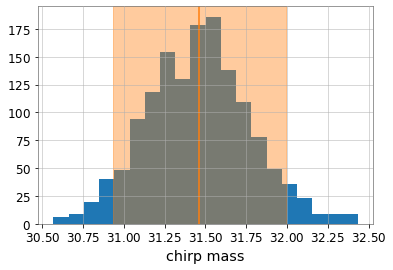

In [22]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()

The result object also has in-built methods to make nice plots such as corner plots. You can add the priors if you are only plotting parameters which you sampled in, e.g.

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject


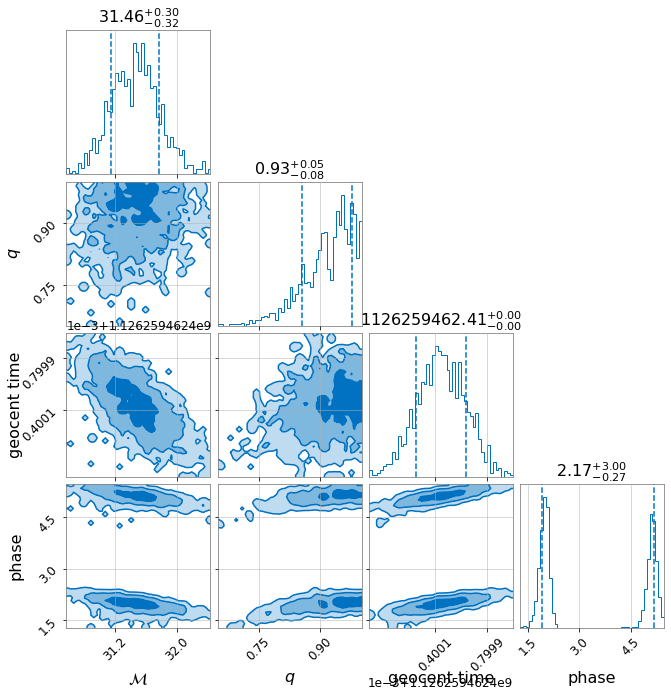

In [23]:
result_short.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase"], prior=True)

You can also plot lines indicating specific points. Here, we add the values recorded on [GWOSC](https://www.gw-openscience.org/events/GW150914/). Notably, these fall outside the bulk of the posterior uncertainty here. This is because we limited our prior - if instead we ran the full analysis these agree nicely.

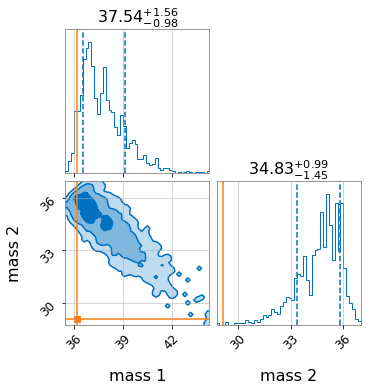

In [24]:
parameters = dict(mass_1=36.2, mass_2=29.1)
result_short.plot_corner(parameters)

Earlier we discussed the "correlation" - in this plot we start to see the correlation between $m_1$ and $m_2$.

### Meta data
The result object also stores meta data, like the priors

In [25]:
result_short.priors

{'chirp_mass': Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'phase': Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, boundary=None),
 'geocent_time': Uniform(minimum=1126259462.3000002, maximum=1126259462.5, name='geocent_time', latex_label='$t_c$', unit=None, boundary=None),
 'a_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'a_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_12': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_jl': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'dec': DeltaFunction(peak=-1.2232, name=None, 

and details of the analysis itself:

In [26]:
result_short.sampler_kwargs["nlive"]

500

Finally, we can also get out the Bayes factor for the signal vs. Gaussian noise. This quantifies the probability that the analyzed segment contains a binary black hole signal compared to just containing noise.

In [27]:
print("ln Bayes factor = {} +/- {}".format(
    result_short.log_bayes_factor, result_short.log_evidence_err))

ln Bayes factor = 268.13578405245494 +/- 0.12132036401988733
